# Preparing Time Series from Wide-Form Data

DataSet: https://www.zillow.com/research/data/

## Imports/Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticks
import matplotlib.dates as mdates
import seaborn as sns
import datetime as dt
import os

import pmdarima as pm
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs

plt.rcParams['figure.figsize']=(12,3)

## Functions

In [2]:
def millions(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in millions"""
    new_x = x/1_000_000
    return f"{new_x:,.0f}M"
def thousands(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in millions"""
    new_x = x/1_000
    return f"{new_x:,.0f}K"
# Create the formatters
fmt_mill = mticks.FuncFormatter(millions)
fmt_thous = mticks.FuncFormatter(thousands)

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100
    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")
    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [4]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])


In [5]:
### NEW FUNCTION FOR COMBINED ACF/PACF WITH ANNOTATIONS
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)
    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)
    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")
        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 
        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")
    fig.tight_layout()
    
    return fig

In [6]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)
    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)
    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")
    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)
    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

## Load Data: Zillow

In [7]:
df = pd.read_csv('Data/Zillow.csv')
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0,255517.0,...,741586.0,745686.0,750578.0,756734.0,762321.0,768797.0,773944.0,777692.0,779960.0,781622.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0,234401.0,...,924019.0,928991.0,937936.0,953874.0,973168.0,990391.0,992337.0,992630.0,978196.0,966595.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0,109079.0,...,245783.0,248718.0,252080.0,256435.0,261101.0,265558.0,268901.0,271059.0,272400.0,272639.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0,166536.0,...,302821.0,305104.0,306404.0,308303.0,309649.0,312487.0,314663.0,315910.0,315587.0,315429.0
4,6915,4,San Antonio,city,TX,TX,"San Antonio-New Braunfels, TX",Bexar County,114794.0,114975.0,...,269323.0,274032.0,278464.0,284127.0,289739.0,294776.0,297727.0,298796.0,299124.0,298951.0


# Part 1: Data Transformation

## Data Exploration

In [8]:
#Identify Columns
df.columns

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'Metro', 'CountyName', '2000-01-31', '2000-02-29',
       ...
       '2021-12-31', '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30',
       '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31', '2022-09-30'],
      dtype='object', length=281)

In [9]:
#Filter only the top 4 ranked by sizerank
rank = df['SizeRank'] < 4

df = df[rank]
df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0,255517.0,...,741586.0,745686.0,750578.0,756734.0,762321.0,768797.0,773944.0,777692.0,779960.0,781622.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0,234401.0,...,924019.0,928991.0,937936.0,953874.0,973168.0,990391.0,992337.0,992630.0,978196.0,966595.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0,109079.0,...,245783.0,248718.0,252080.0,256435.0,261101.0,265558.0,268901.0,271059.0,272400.0,272639.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0,166536.0,...,302821.0,305104.0,306404.0,308303.0,309649.0,312487.0,314663.0,315910.0,315587.0,315429.0


## Melt the Data to LongForm

In [10]:
#Identify featues vs timedata
features = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName','State', 'Metro', 'CountyName']

In [11]:
#Melt to long form
melted_df = pd.melt(df,id_vars=features)
melted_df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,variable,value
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2000-01-31,253690.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,2000-01-31,234181.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,2000-01-31,109068.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,2000-01-31,166139.0
4,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2000-02-29,255517.0
...,...,...,...,...,...,...,...,...,...,...
1087,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,2022-08-31,315587.0
1088,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2022-09-30,781622.0
1089,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,2022-09-30,966595.0
1090,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,2022-09-30,272639.0


In [12]:
melted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RegionID    1092 non-null   int64  
 1   SizeRank    1092 non-null   int64  
 2   RegionName  1092 non-null   object 
 3   RegionType  1092 non-null   object 
 4   StateName   1092 non-null   object 
 5   State       1092 non-null   object 
 6   Metro       1092 non-null   object 
 7   CountyName  1092 non-null   object 
 8   variable    1092 non-null   object 
 9   value       1087 non-null   float64
dtypes: float64(1), int64(2), object(7)
memory usage: 85.4+ KB


In [13]:
melted_df = melted_df.rename(columns = {'variable':'date', 'value':'House Value'})

In [14]:
melted_df['date'] = pd.to_datetime(melted_df['date'])
melted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   RegionID     1092 non-null   int64         
 1   SizeRank     1092 non-null   int64         
 2   RegionName   1092 non-null   object        
 3   RegionType   1092 non-null   object        
 4   StateName    1092 non-null   object        
 5   State        1092 non-null   object        
 6   Metro        1092 non-null   object        
 7   CountyName   1092 non-null   object        
 8   date         1092 non-null   datetime64[ns]
 9   House Value  1087 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 85.4+ KB


In [15]:
melted_df = melted_df.set_index('date')
melted_df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,House Value
date,,,,,,,,,
2000-01-31,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0
2000-01-31,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0
2000-01-31,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0
2000-01-31,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0
2000-02-29,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,255517.0


In [16]:
#Index info
melted_df.index

DatetimeIndex(['2000-01-31', '2000-01-31', '2000-01-31', '2000-01-31',
               '2000-02-29', '2000-02-29', '2000-02-29', '2000-02-29',
               '2000-03-31', '2000-03-31',
               ...
               '2022-07-31', '2022-07-31', '2022-08-31', '2022-08-31',
               '2022-08-31', '2022-08-31', '2022-09-30', '2022-09-30',
               '2022-09-30', '2022-09-30'],
              dtype='datetime64[ns]', name='date', length=1092, freq=None)

In [17]:
new_df = melted_df.groupby('RegionName').resample('MS').sum(numeric_only=True).copy()
new_df

RegionID  SizeRank  House Value
RegionName date                                       
Chicago    2000-01-01     17426         3     166139.0
           2000-02-01     17426         3     166536.0
           2000-03-01     17426         3     167368.0
           2000-04-01     17426         3     168826.0
           2000-05-01     17426         3     170499.0
...                         ...       ...          ...
New York   2022-05-01      6181         0     768797.0
           2022-06-01      6181         0     773944.0
           2022-07-01      6181         0     777692.0
           2022-08-01      6181         0     779960.0
           2022-09-01      6181         0     781622.0

[1092 rows x 3 columns]

# Part 2: Visuals

In [18]:
unstacked = new_df.unstack(level=0)
unstacked

RegionID                              SizeRank                      \
RegionName  Chicago Houston Los Angeles New York  Chicago Houston Los Angeles   
date                                                                            
2000-01-01    17426   39051       12447     6181        3       2           1   
2000-02-01    17426   39051       12447     6181        3       2           1   
2000-03-01    17426   39051       12447     6181        3       2           1   
2000-04-01    17426   39051       12447     6181        3       2           1   
2000-05-01    17426   39051       12447     6181        3       2           1   
...             ...     ...         ...      ...      ...     ...         ...   
2022-05-01    17426   39051       12447     6181        3       2           1   
2022-06-01    17426   39051       12447     6181        3       2           1   
2022-07-01    17426   39051       12447     6181        3       2           1   
2022-08-01    17426   39051       12447     6181        3       2           1   
2022-09-01    17426   39051       12447     6181        3       2           1   

                    House Value                                  
RegionName New York     Chicago   Houston Los Angeles  New York  
date                                                             
2000-01-01        0    166139.0  109068.0    234181.0  253690.0  
2000-02-01        0    166536.0  109079.0    234401.0  255517.0  
2000-03-01        0    167368.0  108878.0    235513.0  257207.0  
2000-04-01        0    168826.0  108881.0    237589.0  260310.0  
2000-05-01        0    170499.0  108834.0    240113.0  263204.0  
...             ...         ...       ...         ...       ...  
2022-05-01        0    312487.0  265558.0    990391.0  768797.0  
2022-06-01        0    314663.0  268901.0    992337.0  773944.0  
2022-07-01        0    315910.0  271059.0    992630.0  777692.0  
2022-08-01        0    315587.0  272400.0    978196.0  779960.0  
2022-09-01        0    315429.0  272639.0    966595.0  781622.0  

[273 rows x 12 columns]

In [19]:
unstacked.columns

MultiIndex([(   'RegionID',     'Chicago'),
            (   'RegionID',     'Houston'),
            (   'RegionID', 'Los Angeles'),
            (   'RegionID',    'New York'),
            (   'SizeRank',     'Chicago'),
            (   'SizeRank',     'Houston'),
            (   'SizeRank', 'Los Angeles'),
            (   'SizeRank',    'New York'),
            ('House Value',     'Chicago'),
            ('House Value',     'Houston'),
            ('House Value', 'Los Angeles'),
            ('House Value',    'New York')],
           names=[None, 'RegionName'])

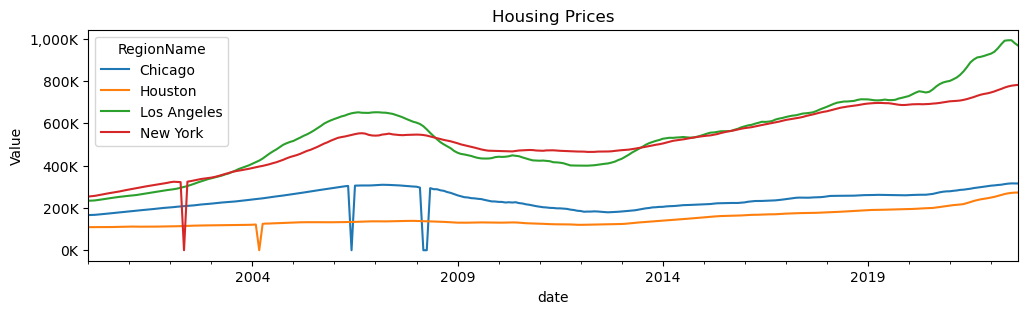

In [20]:
ax = unstacked['House Value'].plot()
ax.set_title('Housing Prices')
ax.set_ylabel('Value')
ax.yaxis.set_major_formatter(fmt_thous)

## Q1: 
Which City had the highest Typical Home Value at the end of 2008? Which had the least?

In [21]:
unstacked.loc[pd.IndexSlice['2008'],:]

RegionID                              SizeRank                      \
RegionName  Chicago Houston Los Angeles New York  Chicago Houston Los Angeles   
date                                                                            
2008-01-01    17426   39051       12447     6181        3       2           1   
2008-02-01    17426   39051       12447     6181        3       2           1   
2008-03-01    17426   39051       12447     6181        3       2           1   
2008-04-01    17426   39051       12447     6181        3       2           1   
2008-05-01    17426   39051       12447     6181        3       2           1   
2008-06-01    17426   39051       12447     6181        3       2           1   
2008-07-01    17426   39051       12447     6181        3       2           1   
2008-08-01    17426   39051       12447     6181        3       2           1   
2008-09-01    17426   39051       12447     6181        3       2           1   
2008-10-01    17426   39051       12447     6181        3       2           1   
2008-11-01    17426   39051       12447     6181        3       2           1   
2008-12-01    17426   39051       12447     6181        3       2           1   

                    House Value                                  
RegionName New York     Chicago   Houston Los Angeles  New York  
date                                                             
2008-01-01        0    300207.0  138208.0    603029.0  546538.0  
2008-02-01        0    296063.0  137512.0    596635.0  546098.0  
2008-03-01        0         0.0  136795.0    586065.0  544562.0  
2008-04-01        0         0.0  136628.0    571226.0  541865.0  
2008-05-01        0    293467.0  136228.0    554589.0  537685.0  
2008-06-01        0    288495.0  135773.0    539622.0  533810.0  
2008-07-01        0    288174.0  135392.0    524220.0  529211.0  
2008-08-01        0    283199.0  134770.0    510520.0  525290.0  
2008-09-01        0    280695.0  133932.0    500124.0  521347.0  
2008-10-01        0    274849.0  133189.0    490979.0  518048.0  
2008-11-01        0    271059.0  132247.0    481905.0  514767.0  
2008-12-01        0    265306.0  131283.0    469294.0  510309.0

### Answer:
Highest = New York
Lowest = Houston

## Q2
How much did the home values change from November 2008 to December 2008 (in dollars)?

In [22]:
q2 = unstacked.diff()
q2

RegionID                              SizeRank                      \
RegionName  Chicago Houston Los Angeles New York  Chicago Houston Los Angeles   
date                                                                            
2000-01-01      NaN     NaN         NaN      NaN      NaN     NaN         NaN   
2000-02-01      0.0     0.0         0.0      0.0      0.0     0.0         0.0   
2000-03-01      0.0     0.0         0.0      0.0      0.0     0.0         0.0   
2000-04-01      0.0     0.0         0.0      0.0      0.0     0.0         0.0   
2000-05-01      0.0     0.0         0.0      0.0      0.0     0.0         0.0   
...             ...     ...         ...      ...      ...     ...         ...   
2022-05-01      0.0     0.0         0.0      0.0      0.0     0.0         0.0   
2022-06-01      0.0     0.0         0.0      0.0      0.0     0.0         0.0   
2022-07-01      0.0     0.0         0.0      0.0      0.0     0.0         0.0   
2022-08-01      0.0     0.0         0.0      0.0      0.0     0.0         0.0   
2022-09-01      0.0     0.0         0.0      0.0      0.0     0.0         0.0   

                    House Value                               
RegionName New York     Chicago Houston Los Angeles New York  
date                                                          
2000-01-01      NaN         NaN     NaN         NaN      NaN  
2000-02-01      0.0       397.0    11.0       220.0   1827.0  
2000-03-01      0.0       832.0  -201.0      1112.0   1690.0  
2000-04-01      0.0      1458.0     3.0      2076.0   3103.0  
2000-05-01      0.0      1673.0   -47.0      2524.0   2894.0  
...             ...         ...     ...         ...      ...  
2022-05-01      0.0      2838.0  4457.0     17223.0   6476.0  
2022-06-01      0.0      2176.0  3343.0      1946.0   5147.0  
2022-07-01      0.0      1247.0  2158.0       293.0   3748.0  
2022-08-01      0.0      -323.0  1341.0    -14434.0   2268.0  
2022-09-01      0.0      -158.0   239.0    -11601.0   1662.0  

[273 rows x 12 columns]

In [23]:
q2.loc[pd.IndexSlice['12/01/2008'],:]

             RegionName 
RegionID     Chicago            0.0
             Houston            0.0
             Los Angeles        0.0
             New York           0.0
SizeRank     Chicago            0.0
             Houston            0.0
             Los Angeles        0.0
             New York           0.0
House Value  Chicago        -5753.0
             Houston         -964.0
             Los Angeles   -12611.0
             New York       -4458.0
Name: 2008-12-01 00:00:00, dtype: float64

### Answer:
Chicago        -5753.0

Houston         -964.0

Los Angeles   -12611.0

New York       -4458.0

# Part 3: Forecasting / Modeling

Your overall goal is to forecast the home values for the city with the highest home value in 2008(New York) 6months into the future (beyond the dataset).

## Data Prep

In [24]:
#create df of NY data only
ny_df = new_df.loc['New York']
ny_df

,RegionID,SizeRank,House Value
date,,,
2000-01-01,6181,0,253690.0
2000-02-01,6181,0,255517.0
2000-03-01,6181,0,257207.0
2000-04-01,6181,0,260310.0
2000-05-01,6181,0,263204.0
...,...,...,...
2022-05-01,6181,0,768797.0
2022-06-01,6181,0,773944.0
2022-07-01,6181,0,777692.0


In [25]:
#Keep only target feature: House Value
ny_df = ny_df.drop(columns = ['RegionID', 'SizeRank'])
ny_df

,House Value
date,
2000-01-01,253690.0
2000-02-01,255517.0
2000-03-01,257207.0
2000-04-01,260310.0
2000-05-01,263204.0
...,...
2022-05-01,768797.0
2022-06-01,773944.0
2022-07-01,777692.0


In [26]:
# Keep only target dates
ny_df = ny_df.loc['2018':'2022']
ny_df

,House Value
date,
2018-01-01,656700.0
2018-02-01,661012.0
2018-03-01,665672.0
2018-04-01,669989.0
2018-05-01,673514.0
2018-06-01,676434.0
2018-07-01,678984.0
2018-08-01,681140.0
2018-09-01,683546.0


In [27]:
ny_df.index

DatetimeIndex(['2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
               '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01',
               '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',
               '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01',
      

## Data Inspection

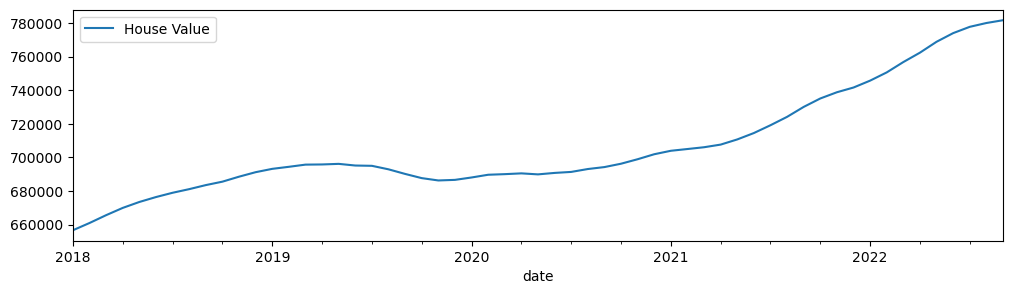

In [28]:
ny_df.plot();

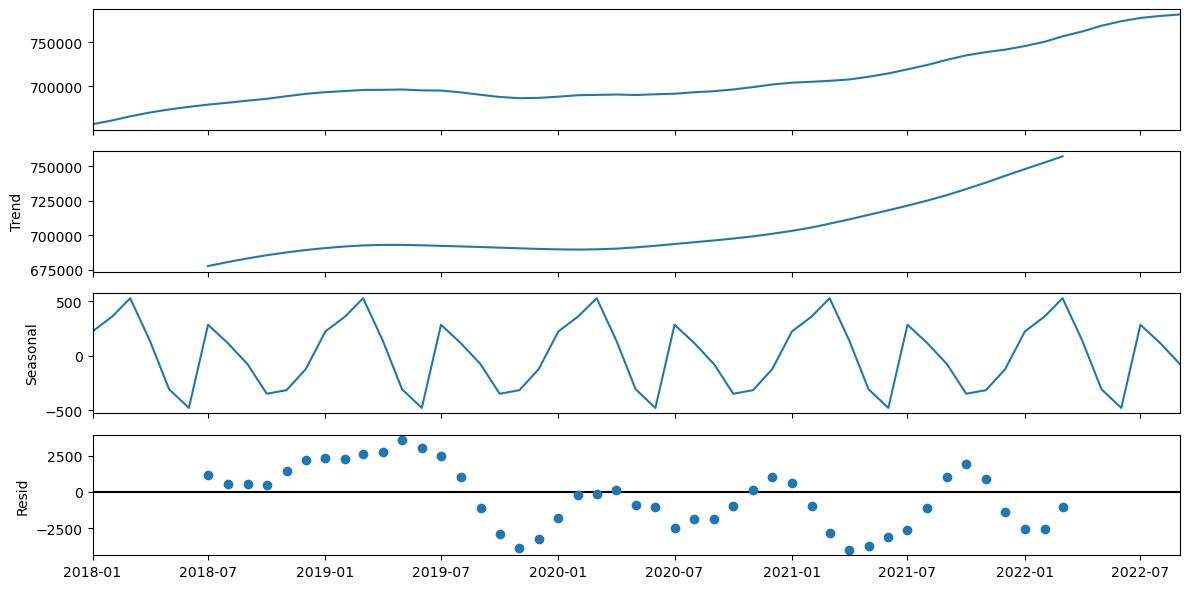

In [29]:
decomp = tsa.seasonal_decompose(ny_df)
fig = decomp.plot()
fig.set_size_inches(12,6)
fig.tight_layout()

In [30]:
max = ny_df["House Value"].max() 
min = ny_df["House Value"].min()

In [31]:
## Seasonality
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()

# How big is the seasonal component relative to the time series?
print(f"The seasonal component is {seasonal_delta: .2f} which is ~{seasonal_delta/(max-min) * 100 :.2f}% of the variation in time series.")

The seasonal component is  1006.13 which is ~0.81% of the variation in time series.


In [32]:
#adfuller
get_adfuller_results(ny_df)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,0.407572,4,52,0.981776,0.05,False


In [33]:
d = ndiffs(ny_df)
print(f'd = {d}')

D = nsdiffs(ny_df, m = 12)
print(f'D = {D}')

d = 2
D = 0


<Axes: xlabel='date'>

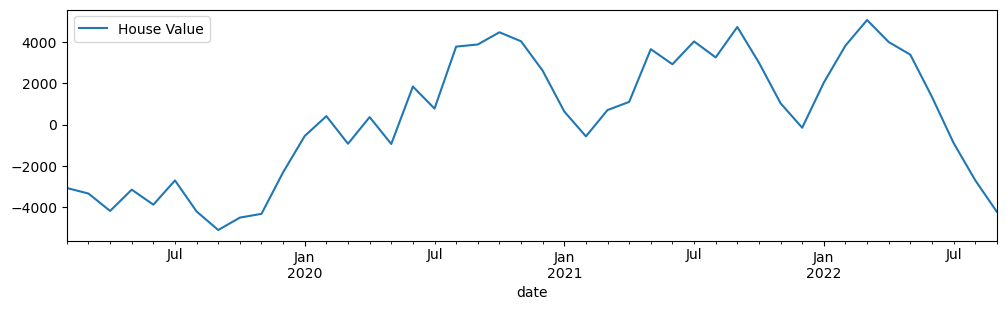

In [34]:
diff = ny_df.diff().diff(12).dropna()
diff.plot()

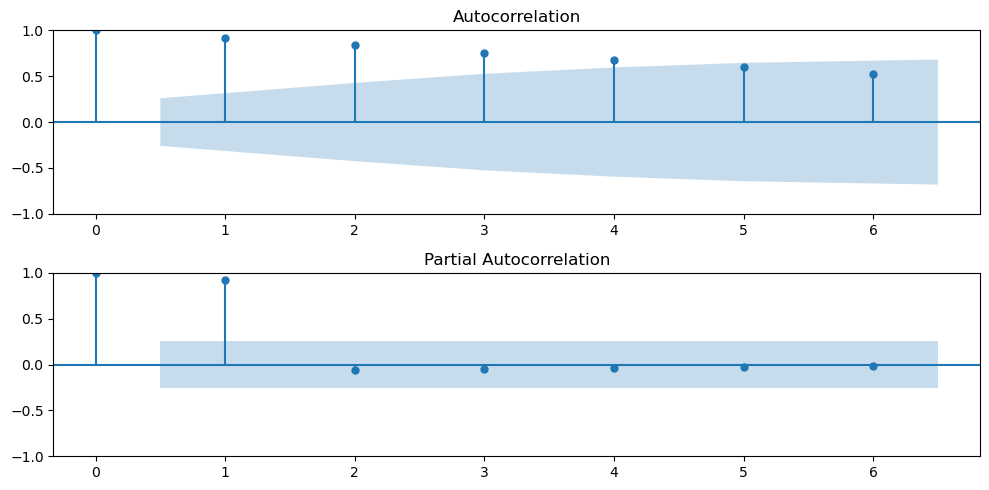

In [35]:
plot_acf_pacf(ny_df, annotate_seas=True, m=12, nlags=6);

## Train Test Split

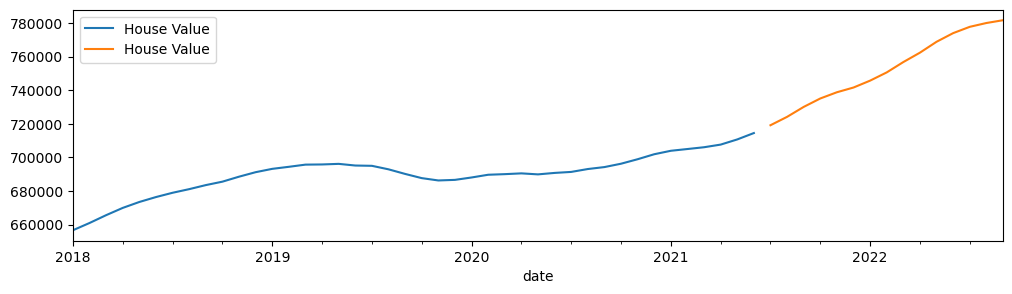

In [36]:
train, test = train_test_split(ny_df, test_size=.25)
ax=train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [37]:
#orders
p = 0
d = 2
q = 0

P = 0
D = 0
Q = 0
m = 12

sarima = tsa.ARIMA(train, order=(p,d,q), seasonal_order=(P,D,Q,m)).fit()

In [38]:
#summary
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            House Value   No. Observations:                   42
Model:                 ARIMA(0, 2, 0)   Log Likelihood                -327.213
Date:                Fri, 03 Nov 2023   AIC                            656.427
Time:                        05:44:28   BIC                            658.116
Sample:                    01-01-2018   HQIC                           657.037
                         - 06-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.446e+05   2.07e+05      3.592      0.000    3.38e+05    1.15e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                 0.87
Prob(Q):                              0.61   Prob(JB):                         0.65
Heteroskedasticity (H):               2.66   Skew:                             0.06
Prob(H) (two-sided):                  0.09   Kurtosis:                         2.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Diagnostic Plots

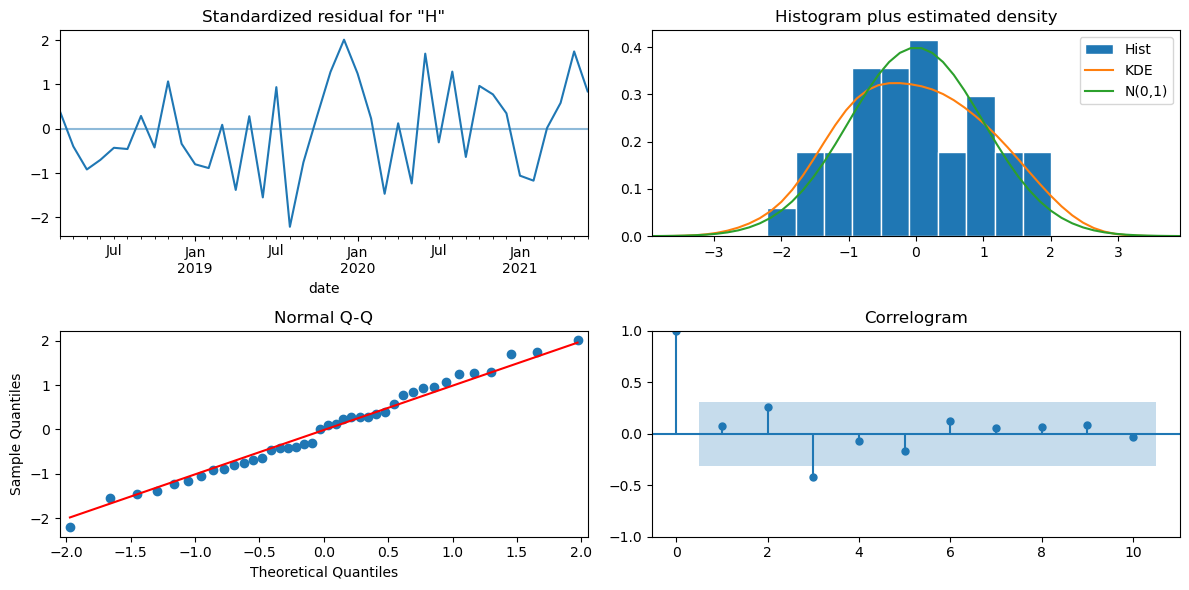

In [39]:
fig = sarima.plot_diagnostics()
fig.set_size_inches(12,6)
fig.tight_layout()

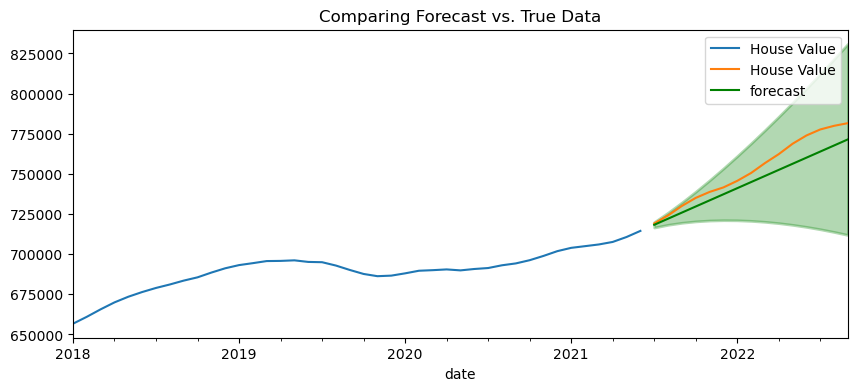

In [59]:
forecasted = sarima.get_forecast(steps=len(test)).summary_frame()

plot_forecast(train, test, forecasted);

In [41]:
#metrics
regression_metrics_ts(test, forecasted['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 7,492.333
- MSE = 73,224,450.200
- RMSE = 8,557.129
- R^2 = 0.822
- MAPE = 0.98%


## Auto Modeling

In [42]:
auto_model = pm.auto_arima(
    train,
    seasonal=True,
    m=12,
    trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=768.631, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=733.235, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=872.953, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=734.033, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=751.534, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=735.153, Time=0.11 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=735.153, Time=0.05 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=737.173, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=740.880, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=734.901, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=745.401, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12] intercept
Total fit time: 1.868 seconds


In [43]:
order = auto_model.order
s_order = auto_model.seasonal_order

print(order)
print(s_order)

(0, 1, 0)
(0, 0, 0, 12)


In [44]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   42
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -364.617
Date:                Fri, 03 Nov 2023   AIC                            733.235
Time:                        05:44:32   BIC                            736.662
Sample:                    01-01-2018   HQIC                           734.483
                         - 06-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1409.9268    290.500      4.853      0.000     840.557    1979.297
sigma2      3.104e+06   7.44e+05      4.170      0.000    1.65e+06    4.56e+06
===================================================================================
Ljung-Box (L1) (Q):                  30.16   Jarque-Bera (JB):                 1.35
Prob(Q):                              0.00   Prob(JB):                         0.51
Heteroskedasticity (H):               0.45   Skew:                            -0.44
Prob(H) (two-sided):                  0.14   Kurtosis:                         2.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

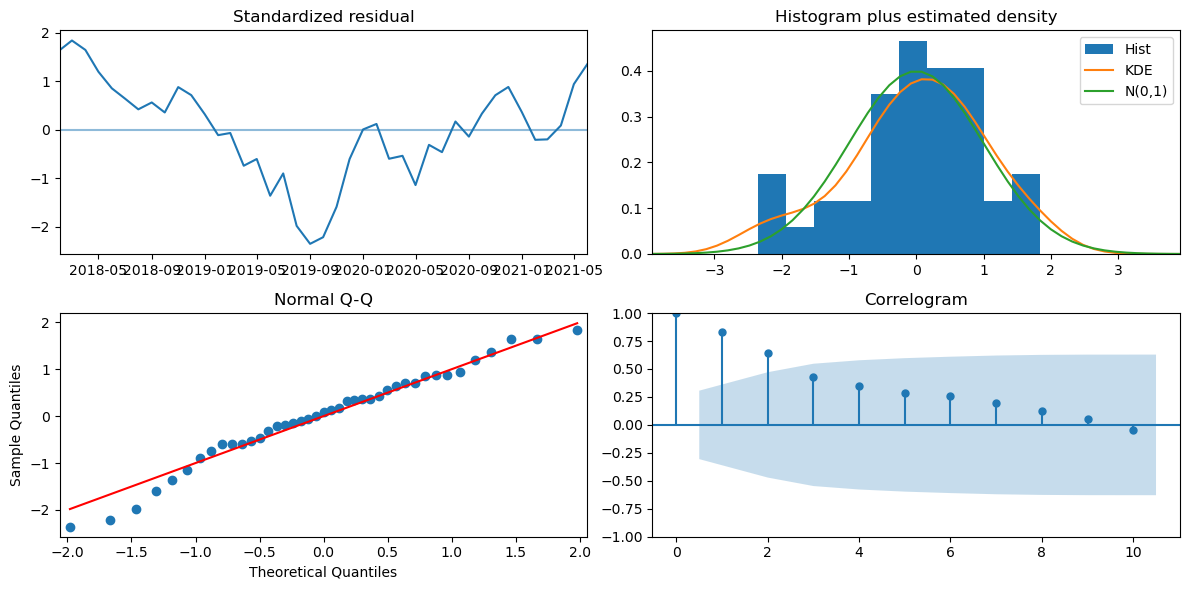

In [45]:
fig = auto_model.plot_diagnostics()
fig.set_size_inches(12,6)
fig.tight_layout()

In [62]:
auto_model = tsa.ARIMA(train, order=order, seasonal_order=s_order).fit()

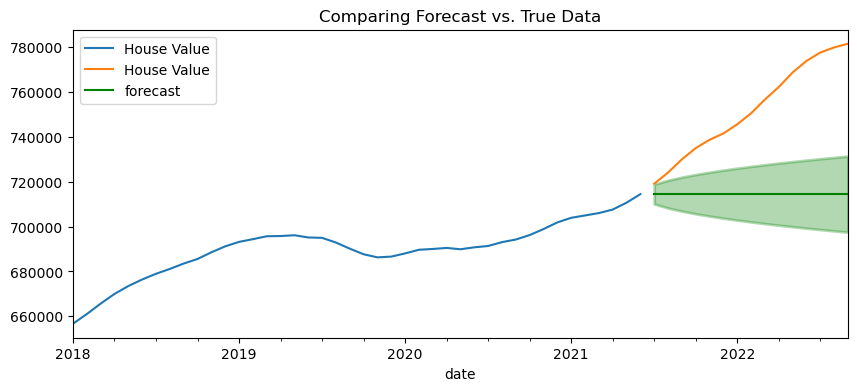

In [66]:
a_forecasted = auto_model.get_forecast(len(test)).summary_frame()

plot_forecast(train, test, a_forecasted);

In [48]:
#metrics
regression_metrics_ts(test, a_forecasted['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 37,900.333
- MSE = 1,846,971,743.000
- RMSE = 42,976.409
- R^2 = -3.499
- MAPE = 4.97%


## Model Comparison:

Model 1: X
- MAE = 7,492.333
- MSE = 73,224,450.200
- RMSE = 8,557.129
- R^2 = 0.822
- MAPE = 0.98%

Model 2: auto model
- MAE = 37,900.333
- MSE = 1,846,971,743.000
- RMSE = 42,976.409
- R^2 = -3.499
- MAPE = 4.97%

Based on all the provided metrics, Model 1 outperforms Model 2 across the board. It has lower errors (MAE, MSE, RMSE), higher R² (indicating better fit), and a lower MAPE (indicating lower percentage error). Therefore, Model 1 is the better-performing model in this comparison.

## Forecasting Values

In [49]:
forecasted.index[0], forecasted.index[-1]

(Timestamp('2021-07-01 00:00:00', freq='MS'),
 Timestamp('2022-09-01 00:00:00', freq='MS'))

In [53]:
first = forecasted['mean'].iloc[0]
first

718308.0

In [54]:
last = forecasted['mean'].iloc[-1]
last

771522.0

In [56]:
difference = last - first
difference

53214.0

In [57]:
percent_difference = (difference / first) * 100
percent_difference

7.408242703686997

# Part 4: Questions

What is the predicted home value in New York City 6 months into the future (beyond the dataset)?

What is the percent change in home values in New York City by the end of the 6-month forecast (beyond the dataset)?

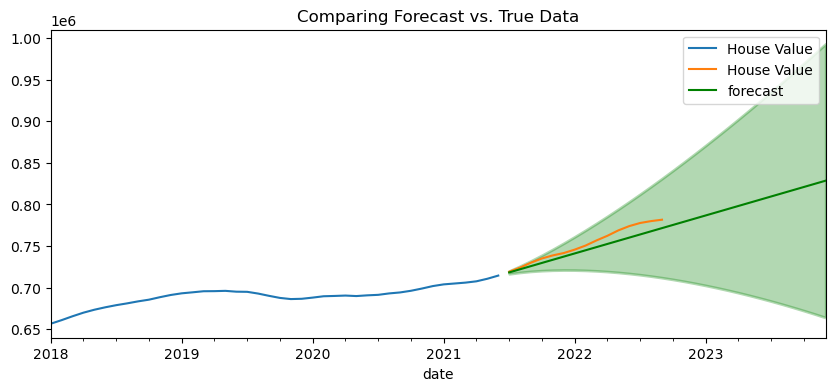

In [67]:
forecast_df = sarima.get_forecast(2*len(test)).summary_frame()
plot_forecast(train, test, forecast_df);

1. $737,313

In [68]:
first = forecast_df['mean'].iloc[0]
last = forecast_df['mean'].iloc[-1]
difference = last - first
percent_difference = (difference / first) * 100
percent_difference

15.345645600494496

2. About %15